Due to 20/01/2025

The objective is to predict the energy consumption in the Wastewater Treatment Plant (WWTP)

**Libraries**

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from scipy.stats import boxcox

**Data import**

In [135]:
df = pd.read_csv('data-melbourne.csv')

**Pre-processing**

Removing predictors with high correlation

In [136]:
df = df.drop(['VG','TM', 'Tm', 'VM'], axis=1)

Removing predictors with low information

In [137]:
df = df.drop(['year', 'month', 'day','SLP','PP', 'VV'], axis=1)

In [138]:
df.head()

,avg_outflow,avg_inflow,total_grid,Am,BOD,COD,TN,T,H,V
0,2.941,2.589,175856,27.0,365.0,730.0,60.378,19.3,56,26.9
1,2.936,2.961,181624,25.0,370.0,740.0,60.026,17.1,63,14.4
2,2.928,3.225,202016,42.0,418.0,836.0,64.522,16.8,47,31.9
3,2.928,3.354,207547,36.0,430.0,850.0,63.000,14.6,49,27.0
4,2.917,3.794,202824,46.0,508.0,1016.0,65.590,13.4,65,20.6


Solving skewness

In [139]:
avg_inflow_bcx, lambda_avg_inflow = boxcox(df['avg_inflow'])

In [140]:
df['avg_inflow'] = avg_inflow_bcx

In [141]:
df.head()

,avg_outflow,avg_inflow,total_grid,Am,BOD,COD,TN,T,H,V
0,2.941,0.461018,175856,27.0,365.0,730.0,60.378,19.3,56,26.9
1,2.936,0.483340,181624,25.0,370.0,740.0,60.026,17.1,63,14.4
2,2.928,0.495022,202016,42.0,418.0,836.0,64.522,16.8,47,31.9
3,2.928,0.499824,207547,36.0,430.0,850.0,63.000,14.6,49,27.0
4,2.917,0.512927,202824,46.0,508.0,1016.0,65.590,13.4,65,20.6


Centering and scaling predictors

In [142]:
df_normalised = df.copy()

In [143]:
columns_to_plot = ['avg_outflow','avg_inflow','Am','BOD','COD','TN','T','H','V']

means = df[columns_to_plot].mean()
stds = df[columns_to_plot].std()

df_normalised[columns_to_plot] = (df[columns_to_plot] - means) / stds

Changing Energy Consumption unit from kWh to MWh for readibility purposes

In [144]:
df_normalised['total_grid'] = (df_normalised['total_grid']/1000)

In [145]:
df_normalised.head()

,avg_outflow,avg_inflow,total_grid,Am,BOD,COD,TN,T,H,V
0,-0.805359,-3.839535,175.856,-1.574715,-0.198401,-0.797436,-0.661643,0.789723,-0.520057,1.039293
1,-0.809428,-2.415153,181.624,-1.832394,-0.140259,-0.728668,-0.760214,0.382202,-0.038434,-0.712176
2,-0.815939,-1.669676,202.016,0.357877,0.417906,-0.068496,0.498805,0.326631,-1.139286,1.739880
3,-0.815939,-1.363199,207.547,-0.415160,0.557448,0.027779,0.072597,-0.080890,-1.001679,1.053304
4,-0.824891,-0.527106,202.824,0.873235,1.464467,1.169328,0.797877,-0.303175,0.099172,0.156552


##### **Model accuracy metrics**

**Residual Sum of Squares**

In [146]:
def calc_rss(y, y_pred):
    rss = sum((y - y_pred)**2)
    
    return rss

**Total Sum of Squares**

In [147]:
def calc_tss(y):
    n = len(y)
    y_avg = sum(y)/n
    tss = sum((y - y_avg)**2)

    return tss

**Root Mean Squared Error**

In [148]:
def calc_rmse(y, y_pred):
    n = len(y)
    mse = (sum((y - y_pred)**2))/n
    rmse = mse**(1/2)
    
    return rmse

$\mathbf{R^2}$

In [149]:
def calc_r2(y, y_pred):
    rss = calc_rss(y, y_pred)
    tss = calc_tss(y)
    r2 = 1 - (rss/tss)

    return r2

##### **Train and test datasets**

In [150]:
X = df_normalised.copy()
X = X.drop(['total_grid'], axis=1)

y = df_normalised['total_grid']

In [151]:
X.insert(0, 'intercept', 1)

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True)

In [204]:
X_train.head()

,intercept,avg_outflow,avg_inflow,Am,BOD,COD,TN,T,H,V
453,1,0.143551,-0.015941,-0.543999,0.528377,0.062163,0.276740,0.808247,-1.896121,-0.291824
549,1,-0.007819,0.285791,1.259753,1.255155,-0.453597,0.065037,1.030531,1.062417,-0.544035
905,1,-0.451349,0.140201,-0.415160,-1.070535,0.509155,-0.091501,-1.247883,1.062417,0.156552
781,1,2.437699,1.547994,2.032790,1.138870,3.122338,1.702377,1.438053,-0.588860,-0.319847
689,1,-0.369967,0.197488,-1.317036,-0.140259,-0.591132,-0.376572,-0.321698,0.030369,0.282658


### **Task 1 - Ordinary Linear Square (OLS) Regression**

$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p + \epsilon$

$\hat{y} = \hat{\beta_0} + \hat{\beta_1} x_1 + \hat{\beta_2} x_2 + \cdots + \hat{\beta_p} x_p$

$RSS = \displaystyle \sum_{i=1}^n (y_i - \hat{y_i})^2 = \sum_{i=1}^{n}(y_1 - \hat{\beta_0} - \hat{\beta_1}x_{i1} - \hat{\beta_2}x_{i2} - \cdots - \hat{\beta_p}x_{ip})^2$

$\hat{\beta} = (\mathbf{X}^T X)^{-1} \mathbf{X}^T y$

#### **From scratch**

In [153]:
def ica_linear_regression(X_train, y_train, X_test, y_test):
    X_T = X_train.T
    B = np.linalg.inv(X_T @ X_train) @ X_T @ y_train

    y_pred = np.dot(X_test, B)

    RMSE = calc_rmse(y_test, y_pred)
    R2 = calc_r2(y_test, y_pred)

    return RMSE, R2

In [154]:
def ica_ridge_regression(L, X_train, y_train, X_test, y_test):
    I = np.identity(X_train.shape[1])

    X_T = X_train.T
    B_ridge = np.linalg.inv(L*I + X_T @ X_train) @ X_T @ y_train

    y_pred_ridge = np.dot(X_test, B_ridge)

    RMSE = calc_rmse(y_test, y_pred_ridge)
    R2 = calc_r2(y_test, y_pred_ridge)
    

    return RMSE, R2, B_ridge

In [155]:
def lasso_regression(B, X_train, y_train, L):
    rss = np.sum((y_train - np.dot(X_train, B)) ** 2)
    l1_penalty = L * np.sum(np.abs(B[1:]))

    total_loss = rss + l1_penalty
    return total_loss

In [156]:
def ica_lasso_regression(B0, X_train, y_train, X_test, y_test, L):
    x0 = np.zeros(X_train.shape[1])
    res = minimize(lasso_regression, x0, args=(X_train, y_train, L))
    B_lasso = res.x
    
    y_pred_lasso = np.dot(X_test, B_lasso)

    RMSE = calc_rmse(y_test, y_pred_lasso)
    R2 = calc_r2(y_test, y_pred_lasso)
    
    return RMSE, R2

In [157]:
def ica_kfold_cross_validation(k, X_train, y_train, model, *args):
    
    n_train = len(X_train)
    fold_length = round(n_train/k)

    indices = np.array(X_train.index)

    k_rmse = np.zeros(k)
    k_r2 = np.zeros(k)

    for fold in range(k):
        start_idx = fold* fold_length
        end_idx = (fold + 1) * fold_length

        validation_indices = indices[start_idx:end_idx]

        train_indices = np.setdiff1d(indices, validation_indices)

        X_train_fold = X_train.loc[train_indices]
        X_val_fold = X_train.loc[validation_indices]

        y_train_fold = y_train.loc[train_indices]
        y_val_fold = y_train.loc[validation_indices]

        if model=='linear_regression':

            rmse, r2 = ica_linear_regression(X_train_fold, y_train_fold, X_val_fold, y_val_fold)

        elif model=='ridge_regression':
            L = args[0]
            rmse, r2, B_ridge = ica_ridge_regression(L, X_train_fold, y_train_fold, X_val_fold, y_val_fold)

        elif model=='lasso_regression':
            L = args[0]
            B0 = args[1:]
            rmse, r2 = ica_lasso_regression(B0, X_train, y_train, X_test, y_test, L)            

        # print(str(fold+1)+": RMSE = " + str(rmse) + " R2 = " + str(r2))
        k_rmse[fold] = rmse
        k_r2[fold] = rmse

    return k_rmse, k_r2

##### **No Cross-Validation**

In [158]:
rmse, r2 = ica_linear_regression(X_train, y_train, X_test, y_test)
print(rmse, r2)

41.38177389113858 0.20004602917868375


##### **5-fold Cross-validation**

In [159]:
l = 1
B0 = np.zeros(X_train.shape[1])
args = [l, B0]

In [160]:
L = args[0]

In [161]:
[rmse, r2] = ica_kfold_cross_validation(5, X_train, y_train, 'linear_regression')

In [162]:
rmse

array([44.68486659, 40.32304493, 43.60071932, 37.53653257, 41.35594515])

In [163]:
k = 10
n_train = len(X_train)
fold_length = round(n_train/k)

indices = np.array(X_train.index)

In [164]:
mse = 0

for fold in range(k):
    start_idx = fold* fold_length
    end_idx = (fold + 1) * fold_length

    validation_indices = indices[start_idx:end_idx]

    train_indices = np.setdiff1d(indices, validation_indices)

    X_train_fold = X_train.loc[train_indices]
    X_val_fold = X_train.loc[validation_indices]

    y_train_fold = y_train.loc[train_indices]
    y_val_fold = y_train.loc[validation_indices]

    rmse, r2 = ica_linear_regression(X_train_fold, y_train_fold, X_val_fold, y_val_fold)
    mse = mse + rmse**(1/2)

    print(str(fold+1)+": RMSE = " + str(rmse) + " R2 = " + str(r2))

CVk = mse/k

print('CV'+str(k)+'='+str(CVk))

1: RMSE = 44.38880898829281 R2 = 0.09633398781368363
2: RMSE = 44.66746005959482 R2 = 0.07508691066404671
3: RMSE = 43.91760025652871 R2 = -0.02295676249778289
4: RMSE = 36.35195713747361 R2 = 0.19133764627643857
5: RMSE = 47.3952060503631 R2 = -0.005229034870105842
6: RMSE = 39.4252346338882 R2 = 0.16420689067029726
7: RMSE = 38.9663008299207 R2 = 0.19812966529324083
8: RMSE = 38.04940563623172 R2 = -0.017595158648616938
9: RMSE = 35.73434229684469 R2 = 0.20327061940711022
10: RMSE = 44.791982046888926 R2 = 0.16553945846407914
CV10=6.424674937377158


#### **From libraries**

##### **No Cross-validation**

In [165]:
import statsmodels.api as sm

In [166]:
model1 = sm.OLS(y, X)
results1 = model1.fit()

In [167]:
r_squared = results1.rsquared
print(r_squared)

0.15238913564145884


##### **5-Fold Cross Validation**

In [168]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [169]:
lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
scores

array([0.08322725, 0.09034178, 0.06817962, 0.14031992, 0.16548113])

##### **10-Fold Cross-Validation**

In [170]:
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=10)
scores

array([ 0.09633399,  0.07508691, -0.02295676,  0.19133765, -0.00522903,
        0.16420689,  0.19635857,  0.02931082,  0.13980995,  0.1635956 ])

### **Task 2: Penalised Linear Regression**

#### **From scratch**

#### **Ridge Regression ($l_2$ penalty)**

*(James, Gareth, et al. 2013)* The Ridge Regression coefficients estimates $\hat{\beta}^R$ are the values that minimize

$\displaystyle \sum_{i=1}^n \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2 + \lambda \sum_{j=1}^{p} \beta_j^2 = RSS + \lambda \sum_{j=1}^p \beta_j^2$

*(Hastie et al. 2017)* The closed form of the Ridge Regression is given by

$\hat{\mathbf{\beta}}^{ridge} = (\mathbf{X^T \mathbf{X}} + \lambda \mathbf{I})^{-1}\mathbf{X}^T \mathbf{y}$

In [171]:
L = np.arange(0,10,0.1)
rmse_L = np.zeros(len(L))
r2_L = np.zeros(len(L))

for i in range(0,len(L)):
    l = L[i]
    RMSE, R2, B_ridge = ica_ridge_regression(l, X_train, y_train, X_test, y_test)
    rmse_L[i] = RMSE
    r2_L[i] = R2
    print(B_ridge)

0    274.782846
1      3.869159
2      5.382914
3     -3.168886
4     -3.915698
5      9.933615
6     -7.092325
7     -8.439752
8      1.455405
9      2.555014
dtype: float64
0    274.756287
1      3.869062
2      5.382715
3     -3.168267
4     -3.915784
5      9.931391
6     -7.090376
7     -8.438527
8      1.455689
9      2.555580
dtype: float64
0    274.729732
1      3.868966
2      5.382515
3     -3.167648
4     -3.915871
5      9.929167
6     -7.088428
7     -8.437302
8      1.455973
9      2.556146
dtype: float64
0    274.703183
1      3.868869
2      5.382316
3     -3.167028
4     -3.915957
5      9.926945
6     -7.086481
7     -8.436078
8      1.456257
9      2.556711
dtype: float64
0    274.676639
1      3.868772
2      5.382116
3     -3.166409
4     -3.916044
5      9.924723
6     -7.084535
7     -8.434854
8      1.456540
9      2.557276
dtype: float64
0    274.650100
1      3.868675
2      5.381917
3     -3.165791
4     -3.916130
5      9.922503
6     -7.082590
7     -8.4336

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_18496\4186729406.py:4: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_xlabel('$\lambda$')


Text(0, 0.5, 'RMSE')

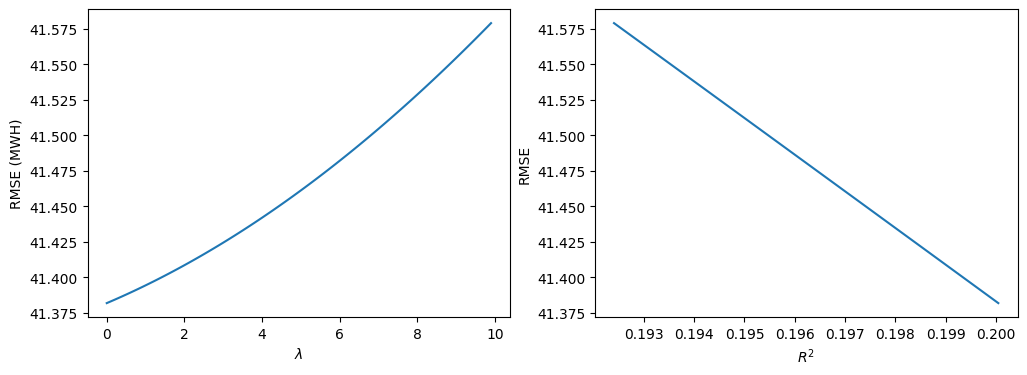

In [172]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.plot(L, rmse_L)
ax1.set_xlabel('$\lambda$')
ax1.set_ylabel('RMSE (MWH)')

ax2.plot(r2_L, rmse_L)
ax2.set_xlabel('$R^2$')
ax2.set_ylabel('RMSE')


##### **5-fold Cross Validation**

In [173]:
L = np.arange(0,100,0.1)
k = 5

rmse_L_k5 = np.zeros((len(L)))

for i in range(0,len(L)):
    l = L[i]
    rmse, r2 = ica_kfold_cross_validation(k, X_train, y_train, 'ridge_regression', l)
    rmse_L_k5[i] = sum(rmse)/k

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_18496\1021591949.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


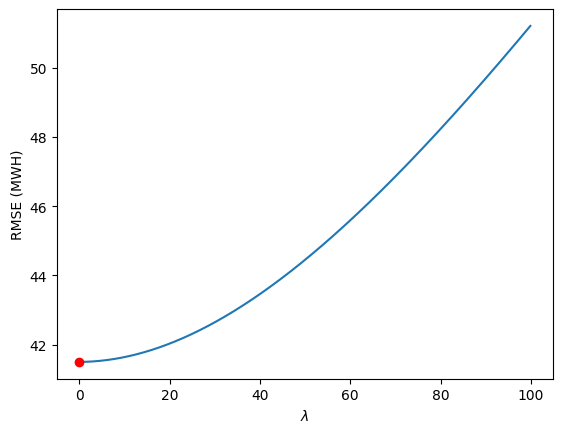

In [174]:
plt.plot(L, rmse_L_k5, zorder=1)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE (MWH)')

min_index = np.argmin(rmse_L_k5)
lambda_min_k5 = L[min_index]
rmse_min_k5 = rmse_L_k5[min_index]

plt.scatter(lambda_min_k5, rmse_min_k5, color='red', zorder=2)

##### **10-Fold Cross-Validation**

In [175]:
L = np.arange(0,100,0.1)
k = 10

rmse_L_k10 = np.zeros((len(L)))

for i in range(0,len(L)):
    l = L[i]
    rmse, r2 = ica_kfold_cross_validation(k, X_train, y_train, 'ridge_regression', l)
    rmse_L_k10[i] = sum(rmse)/k

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_18496\3245871270.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


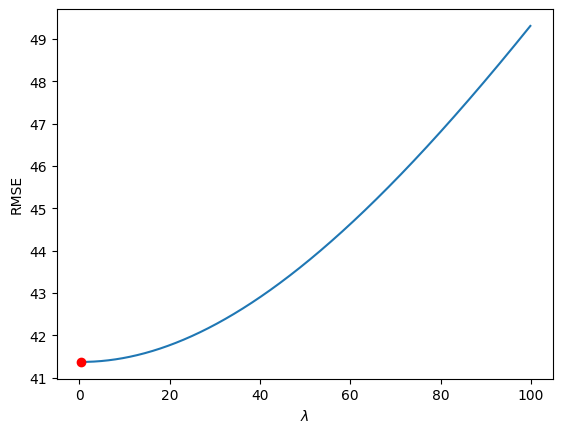

In [176]:
plt.plot(L, rmse_L_k10, zorder=1)

min_index = np.argmin(rmse_L_k10)
lambda_min_k10 = L[min_index]
rmse_min_k10 = rmse_L_k10[min_index]

plt.scatter(lambda_min_k10, rmse_min_k10, color='red', zorder=2)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')

plt.show()

#### **Lasso Regression ($l_1$ penalty)**

(Jamie et al. 2013) The lasso coefficients $\beta_{\lambda}^L$, minimize the quantity

$\displaystyle \sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2 + \lambda \sum_{j=1}^p |\beta_j| = RSS + \lambda \sum_{j=1}^p |\beta_j|$

(Hastie et al. 2017) We can write the residual sum of squares as

$RSS(\beta) = (\mathbf{y} - \mathbf{X}\beta)^T(\mathbf{y} - \mathbf{X}\beta)$

Differentiating with respect to $\beta$ we obtain

$\cfrac{\partial RSS}{\partial \beta} = -2\mathbf{X}^T(\mathbf{y} - \mathbf{X}\beta)$

For the absolute value function $f(\beta) = |\beta|$, we have

$\partial f(\beta) =
\begin{cases}
{+1} & \text{if} \beta > 0\\
{-1} & \text{if} \beta < 0\\
[-1,+1] & \text{if} \beta = 0.
\end{cases}$

In [177]:
from scipy.optimize import minimize

In [178]:
X_train.shape

(1036, 10)

In [179]:
x0 = np.ones(X_train.shape[1])
res = minimize(lasso_regression, x0, args=(X_train, y_train, 1), options={'xatol': 1e-8, 'disp':False})
B_lasso = res.x
print(B_lasso)

C:\Users\room2\AppData\Local\Temp\ipykernel_18496\3228864536.py:2: OptimizeWarning: Unknown solver options: xatol
  res = minimize(lasso_regression, x0, args=(X_train, y_train, 1), options={'xatol': 1e-8, 'disp':False})


[274.78287524   3.86881782   5.3827654   -3.16841853  -3.91490183
   9.93170682  -7.0912611   -8.43984655   1.45474787   2.55438952]


In [180]:
rmse_lasso, r2_lasso = ica_lasso_regression(1, X_train, y_train, X_test, y_test, 1)
print(rmse_lasso)
print(r2_lasso)

41.38186399912204
0.20004254540740596


##### **5-Fold Cross-Validation**

In [181]:
L = np.arange(0,100,1)
k = 5

rmse_L_k5 = np.zeros((len(L),1))

B0 = np.zeros(X_train.shape[1])

for i in range(0,len(L)):
    l = L[i]
    rmse, r2 = ica_kfold_cross_validation(k, X_train, y_train, 'lasso_regression', l, B0)
    rmse_L_k5[i] = sum(rmse)/k

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_18496\236146306.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


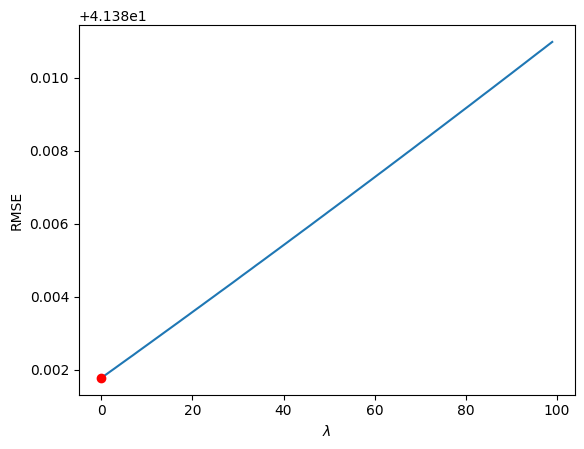

In [182]:
plt.plot(L, rmse_L_k5, zorder=1)

min_index = np.argmin(rmse_L_k5)
lambda_min_k5 = L[min_index]
rmse_min_k5 = rmse_L_k5[min_index]

plt.scatter(lambda_min_k5, rmse_min_k5, color='red', zorder=2)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')

plt.show()

##### **10-Fold Cross-Validation**

In [183]:
L = np.arange(0,100,1)
k = 10

rmse_L_k10 = np.zeros((len(L),1))

B0 = np.zeros(X_train.shape[1])

for i in range(0,len(L)):
    l = L[i]
    rmse, r2 = ica_kfold_cross_validation(k, X_train, y_train, 'lasso_regression', l, B0)
    rmse_L_k10[i] = sum(rmse)/k

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_18496\3245871270.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


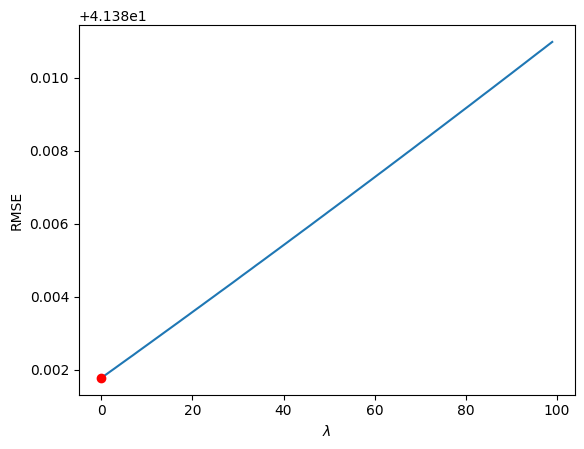

In [184]:
plt.plot(L, rmse_L_k10, zorder=1)

min_index = np.argmin(rmse_L_k10)
lambda_min_k10 = L[min_index]
rmse_min_k10 = rmse_L_k10[min_index]

plt.scatter(lambda_min_k10, rmse_min_k10, color='red', zorder=2)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')

plt.show()

#### **From libraries**

#### **Ridge Regression ($l_2$ penalty)**

In [185]:
from sklearn.linear_model import Ridge

In [186]:
ridgereg = Ridge(alpha=1.0)
ridgereg.fit(X_train, y_train)
y_pred_ridge = ridgereg.predict(X_test)


In [187]:
calc_rmse(y_test, y_pred_ridge)
calc_r2(y_test, y_pred_ridge)

0.20002525732749254

In [188]:
L = np.arange(0,10,0.1)
rmse_L = np.zeros(len(L))
r2_L = np.zeros(len(L))

for i in range(0,len(L)):
    l = L[i]
    
    ridgereg = Ridge(alpha=l)
    ridgereg.fit(X_train, y_train)
    y_pred_ridge = ridgereg.predict(X_test)
    
    rmse_L[i] = calc_rmse(y_test, y_pred_ridge)
    r2_L[i] = calc_r2(y_test, y_pred_ridge)

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_18496\1516381242.py:4: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_xlabel('$\lambda$')


Text(0, 0.5, 'RMSE')

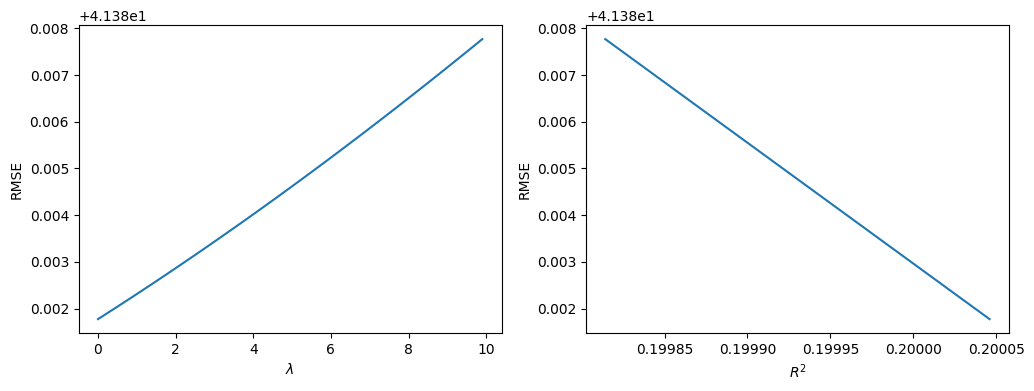

In [189]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.plot(L, rmse_L)
ax1.set_xlabel('$\lambda$')
ax1.set_ylabel('RMSE')

ax2.plot(r2_L, rmse_L)
ax2.set_xlabel('$R^2$')
ax2.set_ylabel('RMSE')

##### **5-Fold Cross-Validation**

In [190]:
lm = LinearRegression()

L = np.arange(0,100,0.1)
k = 5

rmse_L_k5 = np.zeros((len(L)))

for i in range(0,len(L)):
    l = L[i]

    ridgereg = Ridge(alpha=l)

    rmse = cross_val_score(ridgereg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=k)
    rmse_L_k5[i] = sum(rmse)/k

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_18496\2351975880.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


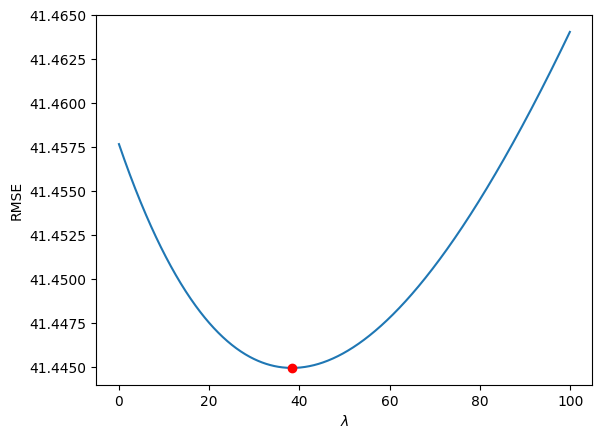

In [191]:
plt.plot(L, -rmse_L_k5, zorder=1)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')

min_index = np.argmin(-rmse_L_k5)
lambda_min_k5 = L[min_index]
rmse_min_k5 = rmse_L_k5[min_index]

plt.scatter(lambda_min_k5, -rmse_min_k5, color='red', zorder=2)

##### **10-Fold Cross-Validation**

In [192]:
lm = LinearRegression()

L = np.arange(0,100,0.1)
k = 10

rmse_L_k10 = np.zeros((len(L)))

for i in range(0,len(L)):
    l = L[i]

    ridgereg = Ridge(alpha=l)

    rmse = cross_val_score(ridgereg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
    rmse_L_k10[i] = sum(rmse)/k

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_18496\1264941061.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


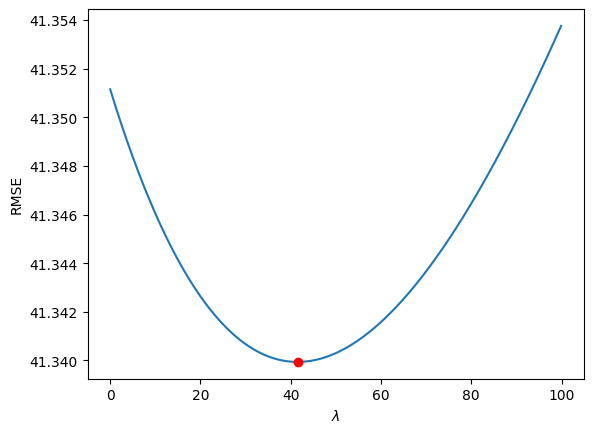

In [193]:
plt.plot(L, -rmse_L_k10, zorder=1)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')

min_index = np.argmin(-rmse_L_k10)
lambda_min_k10 = L[min_index]
rmse_min_k10 = rmse_L_k10[min_index]

plt.scatter(lambda_min_k10, -rmse_min_k10, color='red', zorder=2)

#### **Lasso Regression ($l_2$ penalty)**

In [194]:
from sklearn.linear_model import Lasso

In [195]:
lassoreg = Lasso(alpha=1.0)
lassoreg.fit(X_train, y_train)
y_pred_lasso = lassoreg.predict(X_test)


In [196]:
rmse_lasso = calc_rmse(y_test, y_pred_lasso)
r2_lasso = calc_r2(y_test, y_pred_lasso)

print(r2_lasso)

0.18707394771128305


In [197]:
L = np.arange(0,10,0.1)
rmse_L = np.zeros(len(L))
r2_L = np.zeros(len(L))

for i in range(0,len(L)):
    l = L[i]
    
    lassoreg = Lasso(alpha=l)
    lassoreg.fit(X_train, y_train)
    y_pred_lasso = lassoreg.predict(X_test)
    
    rmse_L[i] = calc_rmse(y_test, y_pred_lasso)
    r2_L[i] = calc_r2(y_test, y_pred_lasso)

c:\Users\room2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\room2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\room2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.734e+05, tolerance: 2.011e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers i

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_18496\1516381242.py:4: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_xlabel('$\lambda$')


Text(0, 0.5, 'RMSE')

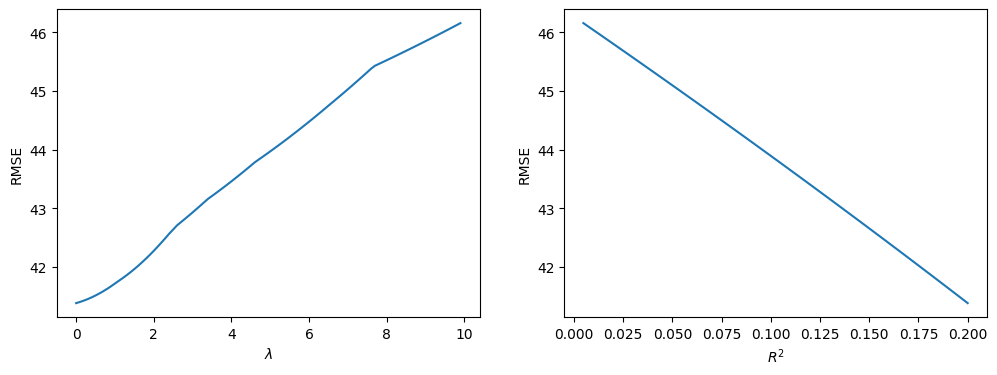

In [198]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.plot(L, rmse_L)
ax1.set_xlabel('$\lambda$')
ax1.set_ylabel('RMSE')

ax2.plot(r2_L, rmse_L)
ax2.set_xlabel('$R^2$')
ax2.set_ylabel('RMSE')

### **Task 3: PCR and PLS Regression**

#### Principal Components Analysis

Covariance Matrix

In [267]:
X_train_for_pca = X_train.copy()
X_test_for_pca = X_test.copy()

X_train_for_pca = X_train_for_pca.drop(['intercept'], axis=1)
X_test_for_pca = X_test_for_pca.drop(['intercept'], axis=1)

In [268]:
cov_matrix = np.dot(X_train_for_pca.T, X_train_for_pca)/len(X_train_for_pca)
cov_eigenvalues, cov_eigenvectors = np.linalg.eig(cov_matrix)

In [269]:
sorted_indices = np.argsort(cov_eigenvalues)[::-1]
eigenvalues_sorted = cov_eigenvalues[sorted_indices]
eigenvectors_sorted = cov_eigenvectors[:, sorted_indices]

explained_variance = (eigenvalues_sorted/sum(eigenvalues_sorted))
explained_variance_cumulative = np.cumsum(explained_variance)

In [270]:
print(explained_variance_cumulative)

[0.27380512 0.46404704 0.62688722 0.72797025 0.82092572 0.8794997
 0.92785197 0.97073536 1.        ]


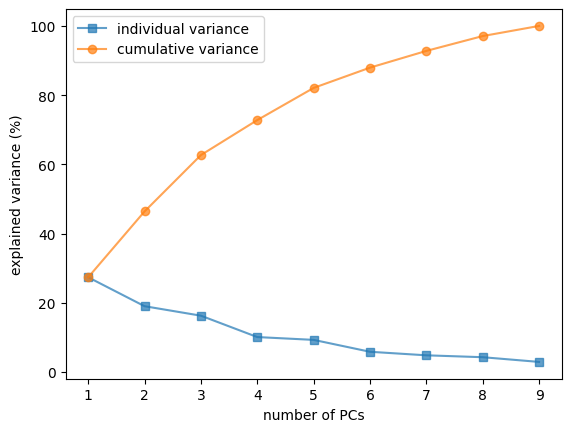

In [271]:
plt.plot(range(1,len(explained_variance_cumulative)+1), explained_variance*100, marker='s', alpha=0.7, label='individual variance')
plt.plot(range(1,len(explained_variance_cumulative)+1), explained_variance_cumulative*100, marker='o', alpha=0.7, label='cumulative variance')
plt.xlabel('number of PCs')
plt.ylabel('explained variance (%)')
plt.legend()
plt.show()

In [322]:
k = 9
V_k = eigenvectors_sorted[:, :k]
X_train_pca = np.dot(X_train_for_pca, V_k)
X_test_pca = np.dot(X_test_for_pca, V_k)

In [323]:
X_train_pca = np.column_stack((np.ones(X_train_pca.shape[0]), X_train_pca))
X_test_pca = np.column_stack((np.ones(X_test_pca.shape[0]), X_test_pca))


In [324]:
rmse_pcr, r2_pcr = ica_linear_regression(X_train_pca, y_train, X_test_pca, y_test)

In [325]:
print(rmse_pcr)
print(r2_pcr)

41.38177389113858
0.20004602917868386


#### Partial Least Squares

### **Task 4: Neural Network for Regression**

##### **References**

James, Gareth, et al. *An introduction to statistical learning*. Vol. 112. New York: springer, 2013.

Hastie, Trevor, Robert Tibshirani, and Jerome Friedman. *The elements of statistical learning: data mining, inference, and prediction*. (2017).

Hastie, Trevor, Robert Tibshirani, and Martin Wainwright. "Statistical learning with sparsity." Monographs on statistics and applied probability 143.143 (2015): 8.